### Imports


In [3]:
import transformers
from transformers import pipeline, AutoTokenizer, AutoModelForSequenceClassification, T5ForConditionalGeneration, T5Tokenizer
import nltk
import string
from nltk.corpus import stopwords
from nltk.corpus import wordnet
from nltk.stem import WordNetLemmatizer
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import torch
import multiprocessing
from functools import partial
import concurrent.futures
import pandas as pd
import csv
import matplotlib.pyplot as plt

c:\Users\User\.conda\envs\UW\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Load dataset + data preprocessing

In [31]:
n = 200
df=pd.read_csv('datasets/US_stocks.csv')
labels = df['Sector'].unique()
df=df.head(n=n)
sentences = df['Description']
labels.shape

(11,)

### Histogram plot & save Function

In [4]:
def plot_histogram(data, types, filename):
    # Extract the items and their frequencies from the dictionary
    items = list(data.keys())
    frequencies = list(data.values())

    # Create a bar plot using matplotlib
    plt.bar(items, frequencies)

    # Rotate the tick labels to display them vertically
    plt.xticks(rotation='vertical')

    # Add labels and title
    plt.xlabel('Items')
    plt.ylabel('Frequency')
    plt.title(types)

     # Save the plot to the specified filename
    plt.savefig(filename)

    # Display the plot
    plt.show()

### Count label function

In [28]:
def label_count(df, types):

    df_label_freq = {}
    df.drop(['Description', 'Ticker', 'Company Name', 'Comment'], inplace=True, axis=1)
    df_type = df[types.split(' ')[0]]


    for label in df_type:
        if label in df_label_freq.keys():
            df_label_freq[label]+=1
        else:
            df_label_freq[label] = 1
    
    return df_label_freq

### Plot and save data histograms

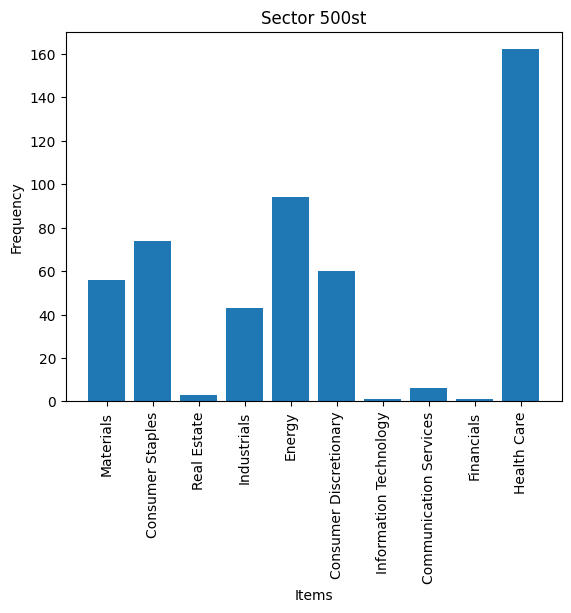

In [29]:
types = f"Sector {n}st"

df_label_freq = label_count(df, types)

plot_histogram(df_label_freq, types, f"graphs/{types.lower().replace('-','_').replace(' ', '_')}_hist.png")

### Create balanced subsets funtion

In [1]:
def balance_df(df, n):

    #US_stocks_sector_df = df.drop(['Ticker', 'Company Name', 'Comment'], inplace=True, axis=1)
    df.drop(['Ticker', 'Company Name', 'Comment'], inplace=True, axis=1)


    sector_dic_count={}

    sector_lst = df['Sector'].unique()

    for sector in sector_lst:
        sector_dic_count[sector] = n//len(labels)

    if n%len(labels)!=0:
        sector_dic_count[sector_dic_count.keys()[0]] += 1
        sector_dic_count[sector_dic_count.keys()[1]] += 1

    #TODO fix the subset size

    dic_df={
        'Description': [],
        'Sector': []
    }

    for idx, row in df.iterrows():
        if n%len(sector_lst) != 0:
            if sector_dic_count[row['Sector']] > 0:
                dic_df['Description'].append(row['Description'])
                dic_df['Sector'].append(row['Sector'])
                sector_dic_count[row['Sector']]-=1
        else:
            if sector_dic_count[row['Sector']] < n//len(labels):
                dic_df['Description'].append(row['Description'])
                dic_df['Sector'].append(row['Sector'])
                sector_dic_count[row['Sector']]+=1
    
    print(idx)

    return pd.DataFrame(dic_df)

In [5]:
#TESTS
n = 200
df=pd.read_csv('datasets/US_stocks.csv')
labels = df['Sector'].unique()
balanced_df = balance_df(df, n)
#len(balanced_df)
#US_stocks_sector_df = df.drop(['Ticker', 'Company Name', 'Comment'], inplace=True, axis=1)
#print(US_stocks_sector_df)


TypeError: 'dict_keys' object is not subscriptable

# Tokenize + Punctuation removal + Lemmatize

In [6]:
def tokenizer(sentence):
    lemmatizer=WordNetLemmatizer()
    tokens = nltk.word_tokenize(sentence.lower())
    stop_words = stopwords.words('english')
    words = [lemmatizer.lemmatize(word,get_wordnet_pos(word)) for word in tokens if word not in string.punctuation]
    sentence=' '.join(words)
    return sentence

def get_wordnet_pos(word):
    tag = nltk.pos_tag([word])[0][1][0].upper()
    tag_dict = {"J": wordnet.ADJ,
                "N": wordnet.NOUN,
                "V": wordnet.VERB,
                "R": wordnet.ADV}

    return tag_dict.get(tag, wordnet.NOUN)

def text_summarization(input_text, max_length=150):
    model = T5ForConditionalGeneration.from_pretrained("t5-small")
    tokenizer = T5Tokenizer.from_pretrained("t5-small")

    input_text = "summarize: " + input_text
    input_ids = tokenizer.encode(input_text, return_tensors="pt", max_length=512, truncation=True)

    summary_ids = model.generate(input_ids, max_length=max_length, num_beams=2, early_stopping=True)
    summary = tokenizer.decode(summary_ids[0], skip_special_tokens=True)

    return summary

def process_sentence(sentence):
    preprocessed_sentence = tokenizer(sentence)
    summary = text_summarization(preprocessed_sentence, 180)
    return summary

with concurrent.futures.ThreadPoolExecutor(max_workers=8) as executor:
    sentences = list(executor.map(process_sentence, sentences))

#sentences=[text_summarization(tokenizer(sentence),180) for sentence in sentences]


# mDeBERTa with CUDA support for faster compute times

In [7]:
#tokenizer = AutoTokenizer.from_pretrained("bert-base-cased", use_fast=True,batched=True, numprocs=8)
classifier = transformers.pipeline("zero-shot-classification", model="MoritzLaurer/mDeBERTa-v3-base-mnli-xnli")#, tokenizer=tokenizer) 
prediction = [classifier(sentence, labels, multi_label=True) for sentence in sentences]

c:\Users\User\.conda\envs\UW\lib\site-packages\transformers\convert_slow_tokenizer.py:470: UserWarning: The sentencepiece tokenizer that you are converting to a fast tokenizer uses the byte fallback option which is not implemented in the fast tokenizers. In practice this means that the fast version of the tokenizer can produce unknown tokens whereas the sentencepiece version would have converted these unknown tokens into a sequence of byte tokens matching the original piece of text.
  warnings.warn(


### Metrics

In [8]:
predicted_label=[prediction[i]['labels'][0] for i in range(df.shape[0])]
df['Predicted Label'] = predicted_label

accuracy = accuracy_score(df['Sector'], df['Predicted Label'])
precision = precision_score(df['Sector'], df['Predicted Label'],average='weighted')
recall = recall_score(df['Sector'], df['Predicted Label'],average='weighted')
f1 = f1_score(df['Sector'], df['Predicted Label'],average='weighted')

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)

Accuracy: 0.574
Precision: 0.5956837088140579
Recall: 0.574
F1 Score: 0.5699839668885501


c:\Users\User\.conda\envs\UW\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


### Save Metrics

In [9]:
#n=200

with open(f'metrics/resultsCPU_{n}.csv',mode='a',newline='') as file:
    writer = csv.writer(file, delimiter=',')
    writer.writerow([n])
    writer.writerow([accuracy])
    writer.writerow([precision])
    writer.writerow([recall])
    writer.writerow([f1])